# Fixed Point Linear Regression on an FPGA

In [1]:
from fixedpoint import FixedPoint
from pynq import Overlay
from pynq import DefaultIP
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class linRegPredDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)
        
    bindto = ['xilinx.com:hls:calcXTX:1.0']
    
    #given array[8] of floats, x and y, will perform linear regression and return best fit y's for same input x's
    def linReg(self, xFloat, yFloat):
        
        xFixed = [FixedPoint(x, True, 16, 16) for x in xFloat]
        yFixed = [FixedPoint(y, True, 16, 16) for y in yFloat]
        
        intBits = []
        for x in xFixed:
            intBits.append(int(x.bits))

        for y in yFixed:
            intBits.append(int(y.bits))

        for i in range(0, 16, 1):
            self.write(i*8+16, intBits[i])
        self.write(0x00, 1)
        
        qformat = {'signed': True, 'm': 16, 'n': 16}
        retFixed = FixedPoint(0, **qformat)
        yOut = []
        for i in range(0, 8, 1):
            out = self.read((i*16)+0x90)
            retFixed.from_string(hex(out))
            yOut.append(float(retFixed))
            
        return yOut

In [3]:
overlay = Overlay('/home/xilinx/pynq/overlays/linRegOverlays/directImp_v3.bit')
#overlay?

In [4]:
X_float = [-1.1, 0.1, 1.2, 2.3, 3.1, 4.1, 4.8, 5.7]
y_float = [-1.7, 2.4, 5.0, 7.3, 10.9, 12.5, 16.2, 19.7]

In [5]:
X_float = [-4.0, -3.3, -2.2, -0.7, 0.1, 1.1, 2.3, 3.4]
y_float = [8.5, 7.6, 5.2, 3.9, 2.1, 0.8, 0.3, -2.1]

In [6]:
absMax = 35.0
X_float = np.sort(np.random.uniform(low=-absMax, high=absMax, size=(8,)))
y_float = np.sort(np.random.uniform(low=-absMax, high=absMax, size=(8,)))
print(X_float, y_float)

[-29.48946419 -20.25098175 -19.99812154 -18.85281397   2.12738397
  14.52540465  26.50526508  27.02662388] [-33.97084156 -19.88727844  -6.65106226  -0.50924704   1.38651786
   8.5166059   17.32425895  28.7143679 ]


In [7]:
%%time
results = overlay.linReg.linReg(X_float, y_float)
print(results)

[-19.83221435546875, -13.297348022460938, -13.118484497070312, -12.308349609375, 2.532012939453125, 11.301788330078125, 19.7757568359375, 20.144546508789062]
CPU times: user 11.9 ms, sys: 144 µs, total: 12 ms
Wall time: 12 ms


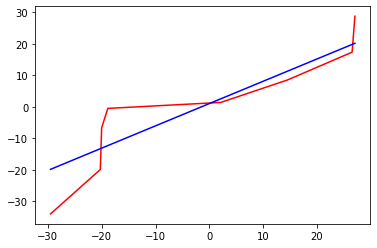

In [8]:
plt.plot(X_float, y_float, color = "#FF0000") #Red is generated numbers
plt.plot(X_float, results, color = "#0000FF") #Blue is hardware output line of best fit

In [9]:
%%time
!python /home/xilinx/python/linear_regression_1.py

Computed parameters: [1.41397352 3.01921841]
Training data  Prediction     Euclidean distance
(x, y)         Python                        
(-1.1, -1.7)   -1.90717       0.20717        
(0.1, 2.4)     1.71590        0.68410        
(1.2, 5.0)     5.03704        0.03704        
(2.3, 7.3)     8.35818        1.05818        
(3.1, 10.9)    10.77355       0.12645        
(4.1, 12.5)    13.79277       1.29277        
(4.8, 16.2)    15.90622       0.29378        
(5.7, 19.7)    18.62352       1.07648        
CPU times: user 148 ms, sys: 48.4 ms, total: 197 ms
Wall time: 1.73 s
